<a href="https://colab.research.google.com/github/gluoneros/greenPredEnergy/blob/main/Trabajo_Final__Revisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GreenPredEnergy - TalentoTech**

Modelo de clasificaci√≥n de viabilidad de proyectos de energia renovable en los municipios de Colombia

## Descripcion üöÄ

A trav√©s del an√°lisis de datos energ√©ticos y meteorol√≥gicos, de los municipios, este modelo evalua y predice la viabilidad de un proyecto de energ√≠a renovable. Con la informaci√≥n que brinda este algoritmo de machine learning los inversores y los gobiernos locales tienen la oportunidad de evaluar y reducir los costos de un proyecto de energ√≠a solar o e√≥lica basandose en un porcentaje de viabilidad predicho por el modelo.


# **Objetivo**
Evaluar la viabilidad de un proyecto de energ√≠a e√≥lica en los municipios de Colombia, por medio de datos meteorol√≥gicos y energ√©ticos del a√±o 2024, con el fin de impulsar el desarrollo municipal del pa√≠s y salvaguardar las inversiones de aquellos interesados en crear un proyecto de energ√≠a renovable, tipo solar o e√≥lico, a trav√©s de un porcentaje de viabilidad.


# **1. Importaciones**

**Requerimientos para consumo de API**

In [1]:
#Cliente de python para consumo de API
!pip install sodapy #requerimientos para usar datos del gobierno

**Bibliotecas**


In [3]:
#Bibliotecas
  # Manejo de datos
import pandas as pd
import numpy as np

  # Visualizaci√≥n de datos
import matplotlib.pyplot as plt
import seaborn as sns

  # Despliegue
import pickle

**Librer√≠as**

In [4]:
#Librer√≠as
  #Modelo
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

  #M√©tricas
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve, roc_auc_score

  #Preprocesamiento
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

  #Cat√°logo de datos abiertos
from sodapy import Socrata

In [5]:
#Clientes de API
client = Socrata("www.datos.gov.co", None)

# **2. Carga y Procesamiento de datos**

En esta secci√≥n se descargar√°n los datasets y se har√°n un preprocesamiento de los datos.

**Dataframe No. 1:**
---
Estado de la prestaci√≥n del servicio de energ√≠a en Zonas No Interconectadas
[enlace](https://www.datos.gov.co/Minas-y-Energ-a/Estado-de-la-prestaci-n-del-servicio-de-energ-a-en/3ebi-d83g/about_data)



**Descarga y agrupamiento de datos**

In [7]:
results1 = client.get("3ebi-d83g", limit=5000) #Del cliente, pyhton va a descargar 5000 archivos

In [8]:
#Carga de datos
datos1 = pd.DataFrame.from_records(results1)
datos1.head()

id_dpto                                      dpto id_mpio  \
0      91                                  AMAZONAS   91001   
1      91                                  AMAZONAS   91540   
2      91                                  AMAZONAS   91798   
3      88  ARCHIPI√âLAGO DE SAN ANDR√âS y PROVIDENCIA   88564   
4      13                                   BOL√çVAR   13001   

                  mpio id_localidad  \
0              LETICIA     91001000   
1        PUERTO NARI√ëO     91540000   
2       TARAPACA (ANM)     91798000   
3          PROVIDENCIA     88564000   
4  CARTAGENA DE INDIAS     13001007   

                                           localidad  anio mes energia_activa  \
0                       LETICIA (LETICIA - AMAZONAS)  2024  06        3994102   
1           PUERTO NARI√ëO (PUERTO NARI√ëO - AMAZONAS)  2024  06         127838   
2               TARAPACA (TARAPACA (ANM) - AMAZONAS)  2024  06          26578   
3  PROVIDENCIA (PROVIDENCIA - ARCHIPI√âLAGO DE SAN...  2024  06        1284196   
4        ISLA FUERTE (CARTAGENA DE INDIAS - BOL√çVAR)  2024  06          60724   

  energia_reactiva potencia_maxima dia_demanda_maxima  \
0          1010671         7824.51             Jueves   
1            40378          256.00          Mi√©rcoles   
2            11917          101.43             Jueves   
3           274864         2241.56          Mi√©rcoles   
4            28336          265.63            Domingo   

      fecha_demanda_maxima prom_diario_horas  
0  2024-06-20T15:30:00.000                24  
1  2024-06-05T18:15:00.000                24  
2  2024-06-20T18:30:00.000             10.18  
3  2024-06-12T14:15:00.000                24  
4  2024-06-30T20:00:00.000               9.4

In [9]:
#Creaci√≥n de una nueva tabla a partir de los variables de inter√©s
df1 = pd.DataFrame(
    {'municipio': datos1['mpio'],
    'potencia_m': datos1['potencia_maxima'],
    'energia_activa': datos1['energia_activa'],
    'energia_reactiva': datos1['energia_reactiva']
    }
)

**Exploraci√≥n de los datos**

In [10]:
# A trav√©s de este comando se analizan las caracter√≠sticas del dataset tales como el tipo del objeto, el tama√±o de la tabla.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4591 entries, 0 to 4590
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   municipio         4591 non-null   object
 1   potencia_m        4591 non-null   object
 2   energia_activa    4591 non-null   object
 3   energia_reactiva  4591 non-null   object
dtypes: object(4)
memory usage: 143.6+ KB


In [11]:
df1.isnull().sum() #conteo de valores nulos en el dataset

municipio           0
potencia_m          0
energia_activa      0
energia_reactiva    0
dtype: int64

In [12]:
#Conversi√≥n de los datos categ√≥ricos de inter√©s a datos num√©ricos
df1['potencia_m'] = pd.to_numeric(df1['potencia_m'], errors='coerce')
df1['energia_activa'] = pd.to_numeric(df1['energia_activa'], errors='coerce')
df1['energia_reactiva'] = pd.to_numeric(df1['energia_reactiva'], errors='coerce')
df1

municipio  potencia_m  energia_activa  energia_reactiva
0                 LETICIA     7824.51         3994102         1010671.0
1           PUERTO NARI√ëO      256.00          127838           40378.0
2          TARAPACA (ANM)      101.43           26578           11917.0
3             PROVIDENCIA     2241.56         1284196          274864.0
4     CARTAGENA DE INDIAS      265.63           60724           28336.0
...                   ...         ...             ...               ...
4586               CARUR√ö       92.14           35746            8582.0
4587                 MIT√ö     3355.10         1632356          385301.0
4588              TARAIRA      138.16           45482           12302.0
4589       PUERTO CARRE√ëO     5147.12         2506803          703817.0
4590              LETICIA     8735.74         4468740         1128508.0

[4591 rows x 4 columns]

In [16]:
# Se verifica conversion a numerico
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4591 entries, 0 to 4590
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         4591 non-null   object 
 1   potencia_m        4591 non-null   float64
 2   energia_activa    4591 non-null   int64  
 3   energia_reactiva  4591 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 143.6+ KB


**Tratamiento de datos**

Valores repetidos

<Axes: xlabel='potencia_m', ylabel='Count'>

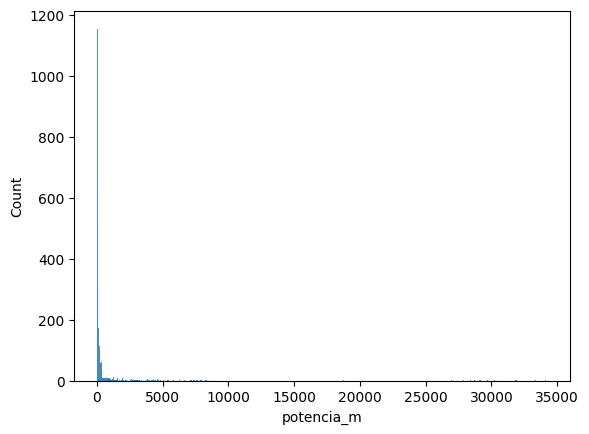

In [17]:
#Visualizaci√≥n de los datos previo a la selecci√≥n posible de media o mediana
sns.histplot(df1['potencia_m'])

<Axes: xlabel='energia_activa', ylabel='Count'>

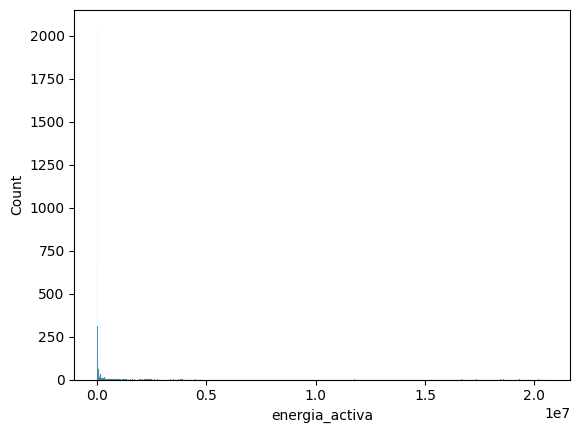

In [18]:
#Visualizaci√≥n de los datos previo a la selecci√≥n posible de media o mediana
sns.histplot(df1['energia_activa'])

<Axes: xlabel='energia_reactiva', ylabel='Count'>

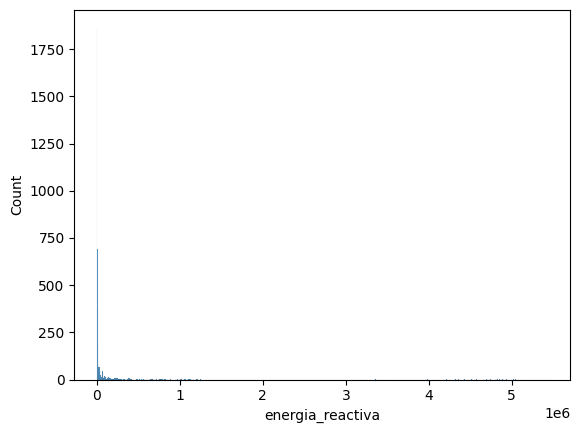

In [19]:
#Visualizaci√≥n de los datos previo a la selecci√≥n posible de media o mediana
sns.histplot(df1['energia_reactiva'])

In [20]:
# Para depurar el dataset de variables repetidas se usa esa esta forma
  # Por cada municipio √∫nico va a sacar la media de los datos correspondientes a este lugar
energy = df1.groupby('municipio').agg({'potencia_m': 'median', 'energia_activa': 'median', 'energia_reactiva': 'median'}).reset_index()
#Creamos una tabla nueva con los datos √∫nicos
energy

municipio  potencia_m  energia_activa  energia_reactiva
0                     ACANDI    1016.225        496707.5         170400.15
1                     ACAND√ç     898.570        377087.5         135449.00
2                 ALTO BAUDO     127.335         52319.0          17949.00
3   ALTO BAUDO (PIE DE PATO)     108.590         46705.0          16143.49
4                 ALTO BAUD√ì     114.050         47341.0          15989.00
..                       ...         ...             ...               ...
90                    UNGU√çA      93.020         20520.0           8206.00
91                    URIBIA     234.000         37058.0          11120.00
92                    URIB√çA     189.920         44960.5          11393.00
93          VIGIA DEL FUERTE      35.810          3567.0            393.35
94          VIG√çA DEL FUERTE      42.015          5383.5           1402.50

[95 rows x 4 columns]

N√≥tese que de 4273 municipios repetidos pasamos a 95 municipios √∫nicos

In [21]:
# Evaluaci√≥n de los municipios
energy['municipio'].value_counts().sum()

np.int64(95)

In [22]:
# An√°lisis de caractar√≠ticas
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         95 non-null     object 
 1   potencia_m        95 non-null     float64
 2   energia_activa    95 non-null     float64
 3   energia_reactiva  95 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.1+ KB


**Visualizaci√≥n de los datos**

Media: 1052.1614210526316
Mediana: 89.96


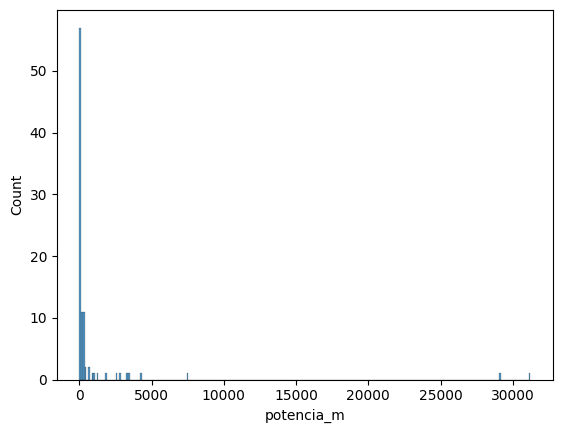

In [23]:
#Visualizaci√≥n de los datos de energ√≠a reactiva con sus medias y medianas
sns.histplot(energy['potencia_m'])
print('Media:',energy['potencia_m'].mean())
print('Mediana:', energy['potencia_m'].median())

Media: 574443.4631578948
Mediana: 21208.5


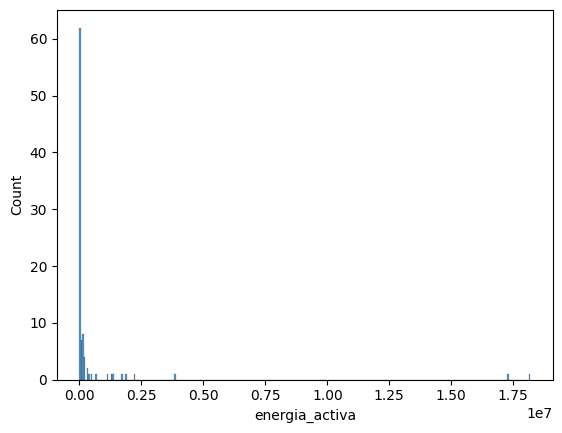

In [24]:
#Visualizaci√≥n de los datos de energ√≠a activa con sus medias y medianas
sns.histplot(energy['energia_activa'])
print('Media:', energy['energia_activa'].mean())
print('Mediana:', energy['energia_activa'].median())

Media: 163217.39868421055
Mediana: 8182.0


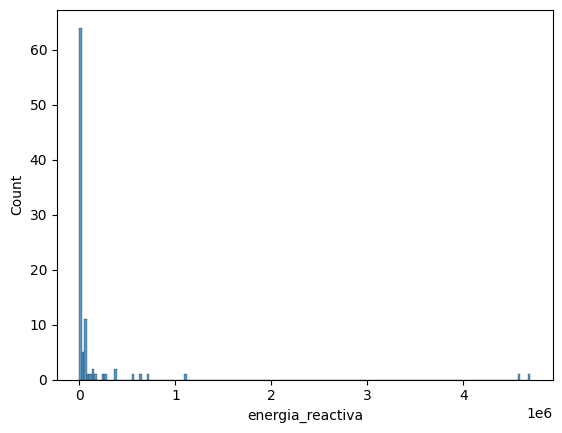

In [25]:
#Visualizaci√≥n de los datos de energ√≠a reactiva con sus medias y medianas
sns.histplot(energy['energia_reactiva'])
print('Media:',energy['energia_reactiva'].mean())
print('Mediana:', energy['energia_reactiva'].median())

<Axes: >

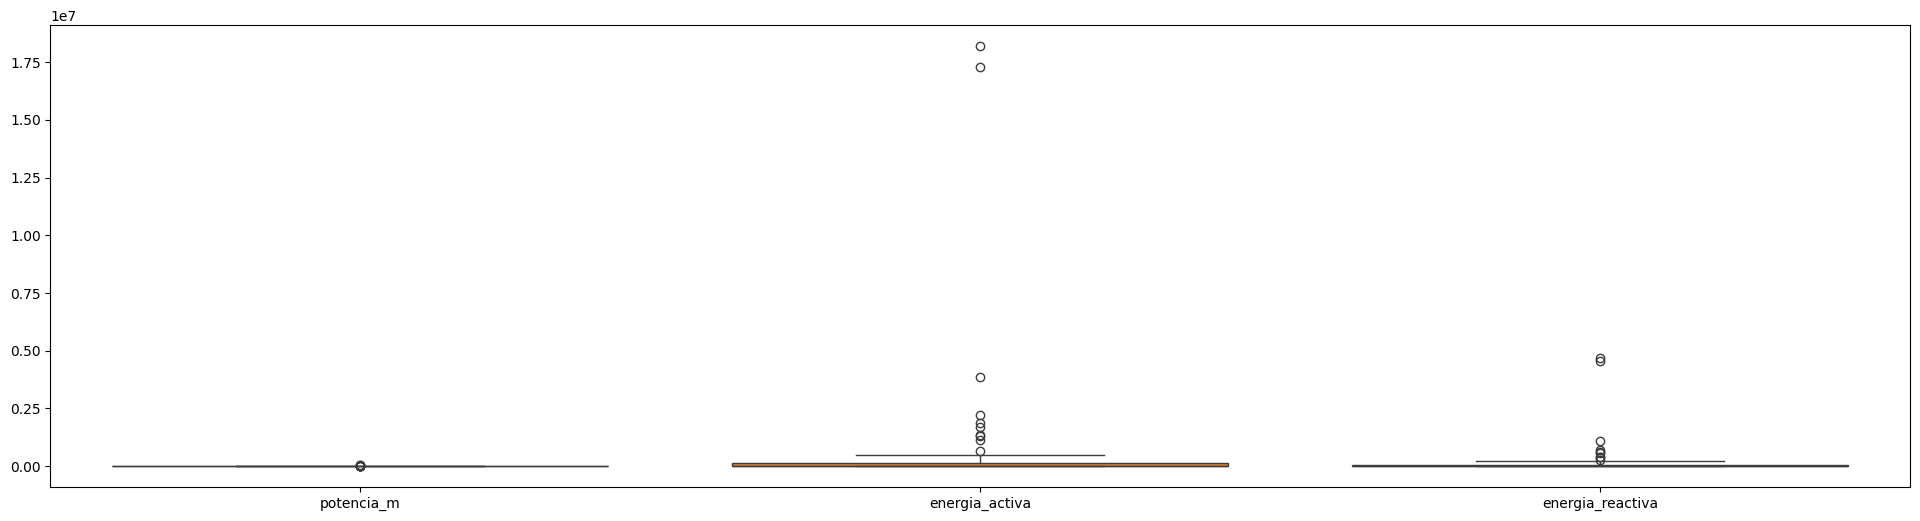

In [26]:
#visualizaci√≥n de la calidad de los datos
plt.figure(figsize=(24, 6))
columnas = energy[['potencia_m', 'energia_activa', 'energia_reactiva']]
sns.boxplot(columnas, whis=3)

Notemos que los datos de energ√≠a tienen muchos **datos atipicos**, adem√°s de una escala inmensa, a comparaci√≥n con potencia m√°xima

<Axes: >

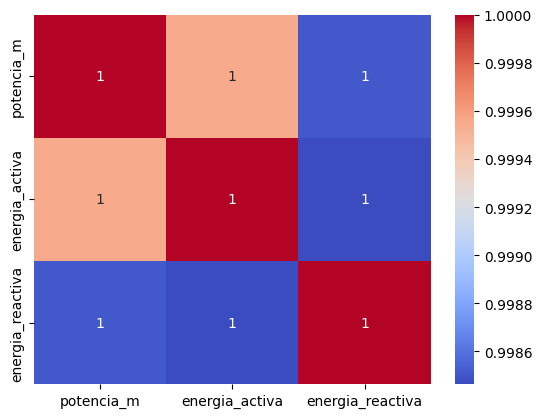

In [27]:
#Analisis de correlacion multivariada entre las variables de interes.
correlacion1 = energy[['potencia_m', 'energia_activa',	'energia_reactiva']].corr()
sns.heatmap(correlacion1, annot=True, cmap='coolwarm')

Existe una multicolinealidad muy alta entre las variables, esto significa que hay correlacion fuerte.

**Dataframe No. 2:**
---
Velocidad del viento en los municipios de colombia
[v√≠nculo](https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/Velocidad-Viento/sgfv-3yp8/about_data)


**Descarga y agrupamiento de lo datos**

In [29]:
#Descarga y emuestra el dataset
results2 = client.get("sgfv-3yp8", limit=3000)
datos2 = pd.DataFrame.from_records(results2)
datos2

codigoestacion codigosensor         fechaobservacion valorobservado  \
0        0021206960         0103  2008-11-24T13:20:00.000            1.5   
1        0029065501         0103  2018-12-05T06:20:00.000    0.004240164   
2        0021015070         0103  2007-11-21T20:10:00.000            2.2   
3        0026125290         0103  2007-11-06T20:00:00.000            1.6   
4        0024055080         0103  2018-02-20T11:10:00.000            1.5   
...             ...          ...                      ...            ...   
2995     0021197430         0103  2010-01-05T08:20:00.000           4.42   
2996     0012015100         0103  2017-08-28T03:40:00.000            1.1   
2997     0029035000         0103  2018-08-30T09:40:00.000            0.8   
2998     0024030950         0103  2018-12-18T18:50:00.000            0.7   
2999     0026125505         0103  2016-09-23T08:35:00.000            1.3   

                 nombreestacion  departamento        municipio  \
0           IDEAM BOGOTA  - AUT        BOGOTA      BOGOTA, D.C   
1             CIENAGA,LA  - AUT     MAGDALENA          CI√âNAGA   
2          LOS GUACHAROS  - AUT         HUILA        PALESTINA   
3                 ARMENIA - AUT       QUIND√çO          ARMENIA   
4     VIZCAINA LA LIZAMA  - AUT     SANTANDER  BARRANCABERMEJA   
...                         ...           ...              ...   
2995  PROVIDENCIA - PROVIDENCIA  CUNDINAMARCA       FUSAGASUG√Å   
2996         PISTA INDIRA - AUT     ANTIOQUIA            TURBO   
2997            SINCERIN  - AUT       BOLIVAR           ARJONA   
2998                   MALAGA 2     SANTANDER           M√ÅLAGA   
2999            LA BELLA  - AUT       QUIND√çO          CALARC√Å   

      zonahidrografica      latitud      longitud          descripcionsensor  \
0       ALTO MAGDALENA          4.6  -74.06666667  Velocidad Viento (10 min)   
1       BAJO MAGDALENA  10.89785833  -74.08156667  Velocidad Viento (10 min)   
2       ALTO MAGDALENA     1.675833    -76.106841  Velocidad Viento (10 min)   
3                CAUCA  4.531583333  -75.69069444  Velocidad Viento (10 min)   
4             SOGAMOSO  6.982972222  -73.70488889  Velocidad Viento (10 min)   
...                ...          ...           ...                        ...   
2995    ALTO MAGDALENA        4.367         -74.3  Velocidad Viento (10 min)   
2996  CARIBE - LITORAL      7.94075  -76.69616667  Velocidad Viento (10 min)   
2997    BAJO MAGDALENA  10.14258333  -75.27827778  Velocidad Viento (10 min)   
2998          SOGAMOSO  6.706388889  -72.72972222  Velocidad Viento (10 min)   
2999             CAUCA  4.501111111  -75.67138889  Velocidad Viento (10 min)   

     unidadmedida  
0             m/s  
1             m/s  
2             m/s  
3             m/s  
4             m/s  
...           ...  
2995          m/s  
2996          m/s  
2997          m/s  
2998          m/s  
2999          m/s  

[3000 rows x 12 columns]

In [30]:
#Agrupamiento de variables de inter√©s
df2 = pd.DataFrame(
    {'municipio': datos2['municipio'],
     'velocidad_viento': datos2['valorobservado']
    }
)
df2

municipio velocidad_viento
0         BOGOTA, D.C              1.5
1             CI√âNAGA      0.004240164
2           PALESTINA              2.2
3             ARMENIA              1.6
4     BARRANCABERMEJA              1.5
...               ...              ...
2995       FUSAGASUG√Å             4.42
2996            TURBO              1.1
2997           ARJONA              0.8
2998           M√ÅLAGA              0.7
2999          CALARC√Å              1.3

[3000 rows x 2 columns]

**Exploraci√≥n de los datos**

In [31]:
df2.info() #Caracter√≠sticas de los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   municipio         3000 non-null   object
 1   velocidad_viento  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


Notemos que la variable, la velocidad del viento, est√° descrita como un objeto por lo que es necesario transformarla en num√©rico

In [32]:
#pasar la columna velocidad_viento a num√©rico
df2['velocidad_viento'] = pd.to_numeric(df2['velocidad_viento'], errors='coerce')

In [33]:
df2.isnull().sum() #Conteo de valores nulos

municipio           0
velocidad_viento    0
dtype: int64

Media: 1.9711314989148532
Mediana: 1.4


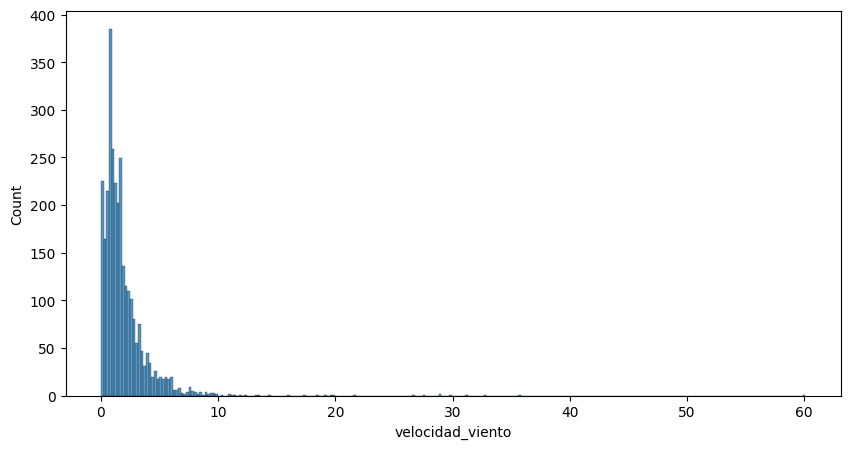

In [34]:
# Con el objetivo agrupar los datasets por municipio se evalua con graficas de boxplot y hisplot cuales datos estadisticos funcionarian mejor para ser un dato unico por cada uno de los municipios(que sera unico) en la columna 'municipio'.
plt.figure(figsize=(10, 5))
sns.histplot(df2['velocidad_viento'])
print('Media:',df2['velocidad_viento'].mean())
print('Mediana:', df2['velocidad_viento'].median())

Media: 1.9711314989148532
Mediana: 1.4


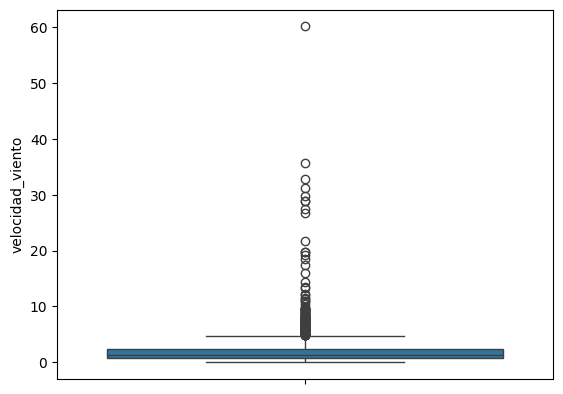

In [35]:
sns.boxplot(df2['velocidad_viento'])
print('Media:',df2['velocidad_viento'].mean())
print('Mediana:', df2['velocidad_viento'].median())

Notemos que la velocidad del viento tiene muchos outliers que afectan el valor de la media, por lo que cualquier tratamiento se recomienda hacer con la **MEDIANA**

**Tratamiento de datos**

Valores repetidos

In [36]:
# Por cada municipio √∫nico va a sacar la mediana de los datos correspondientes a este lugar
viento = df2.groupby('municipio').agg({'velocidad_viento': 'median'}).reset_index()
viento

municipio  velocidad_viento
0             ACAND√ç          1.200000
1            ACEVEDO          1.748343
2          AGUACHICA          1.300000
3    AGUST√çN CODAZZI          1.100000
4            ALBANIA          4.350000
..               ...               ...
295            YOPAL          0.600000
296        ZETAQUIR√Å          0.550000
297        ZIPAQUIR√Å          2.200000
298    ZONA BANANERA          0.850000
299           √ÅBREGO          1.900000

[300 rows x 2 columns]

Media: 1.6422269822898334
Mediana: 1.35


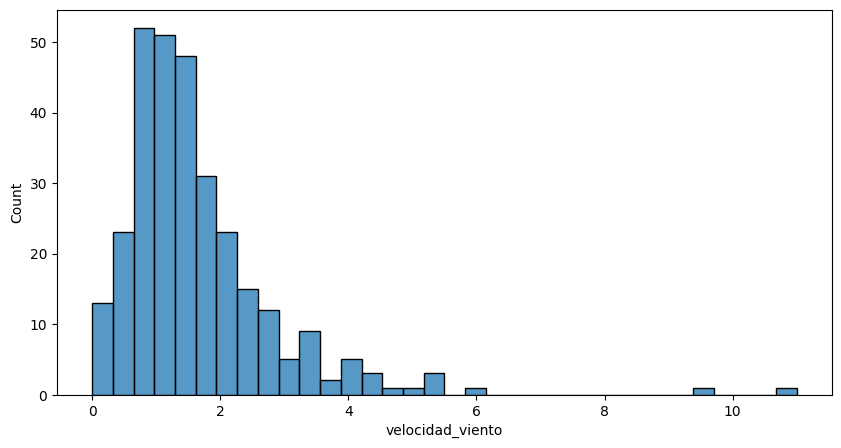

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(viento['velocidad_viento'])
print('Media:',viento['velocidad_viento'].mean())
print('Mediana:', viento['velocidad_viento'].median())

<Axes: ylabel='velocidad_viento'>

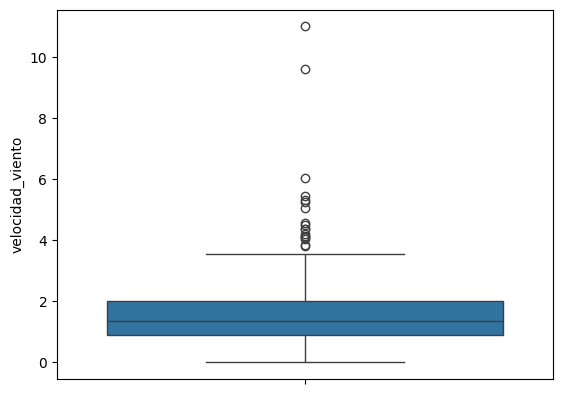

In [38]:
sns.boxplot(viento['velocidad_viento'])

In [39]:
#Evaluaci√≥n del m√©todo
viento['municipio'].value_counts().sum()

np.int64(300)

**Dataframe No. 4:**
---
Dias con lluvia en los municipios de colombia:

INFORMACI√ìN GENERAL ESTACIONES,,,,,,,,,NORMAL CLIMATOL√ìGICA EST√ÅNDAR DE No DE D√çAS CON LLUVIA ‚â• 1 mm PARA EL PERIODO 1991-2020,,,,,,,,,,,,,  Cumplen la directriz No 1203 del 2017 de la OMM, [v√≠nculo](http://archivo.ideam.gov.co/web/tiempo-y-clima/clima)

**Descarga y agrupamiento de los datos**

In [40]:
#Descarga de los datos
datos3 = pd.read_csv('https://raw.githubusercontent.com/gluoneros/talentoTech/refs/heads/main/noDiasLLuvia.csv')
datos3

CODIGO CATEGORIA                   ESTACI√ìN       MUNICIPIO  \
0     47067010        LM                 El Encanto      El Encanto   
1     47060010        PM                  El Encato      El Encanto   
2     44187030        LM                     Bacuri      La Pedrera   
3     44187020        PM                 La Pedrera      La Pedrera   
4     44157040        LM                   Manacaro      La Pedrera   
...        ...       ...                        ...             ...   
1440  38015030        SP  Aeropuerto Puerto Carre√±o  Puerto Carre√±o   
1441  38017040        LM                  Casuarito  Puerto Carre√±o   
1442  35260010        PM                    Bonanza   Santa Rosal√≠a   
1443  35260030        PM              Hato Burrunay   Santa Rosal√≠a   
1444  35267030        LM               Santa Maria    Santa Rosal√≠a   

     DEPARTAMENTO  AO  ALTITUD (m) LONGITUD LATITUD   ENE  ...   JUN   JUL  \
0        Amazonas   7          120   -73,20   -1,77  14,3  ...  18,8  17,7   
1        Amazonas   7          120   -73,21   -1,75  14,3  ...  18,6  17,8   
2        Amazonas   4          101   -69,47   -1,23  19,0  ...  20,3  19,6   
3        Amazonas   4          102   -69,59   -1,31  13,8  ...  14,7  13,5   
4        Amazonas   4          109   -70,18   -1,53  18,3  ...  19,1  18,0   
...           ...  ..          ...      ...     ...   ...  ...   ...   ...   
1440      Vichada   3           57   -67,49    6,18   1,0  ...  21,2  21,9   
1441      Vichada   3           65   -67,64    5,68   2,1  ...  19,3  19,6   
1442      Vichada   3          112   -70,85    5,14   1,1  ...  14,4  15,1   
1443      Vichada   3          106   -70,68    5,35   1,3  ...  15,3  17,1   
1444      Vichada   3          108   -70,71    5,27   1,2  ...  15,6  16,0   

       AGO   SEP   OCT   NOV   DIC  ANUAL  N√∫mero de meses % de cumplimiento  
0     13,4  13,3  13,9  14,8  16,4  191,7              332             92,2%  
1     13,1  13,3  13,8  14,9  16,3  191,1              343             95,3%  
2     16,5  14,5  15,1  15,0  18,8  216,0              343             95,3%  
3     12,4  11,2  12,0  12,1  13,3  161,8              334             92,8%  
4     14,6  13,2  14,9  14,8  17,1  204,0              351             97,5%  
...    ...   ...   ...   ...   ...    ...              ...               ...  
1440  19,7  14,3  12,3   7,9   2,9  133,2              359             99,7%  
1441  16,1  12,7  10,3   7,7   4,3  130,7              343             95,3%  
1442  13,2  10,0   8,9   5,9   2,7   98,7              324             90,0%  
1443  14,0  12,1  10,8   7,7   3,6  113,4              349             96,9%  
1444  13,2  12,4  10,3   6,8   2,8  106,8              328             91,1%  

[1445 rows x 24 columns]

In [41]:
# Se seleccionan y grupan de los datos de  inter√©s en un nuevo dataframe.
dato_lluvia = pd.DataFrame(
    {'municipio': datos3['MUNICIPIO'],
     'dias_lluvia': datos3['ANUAL']
    }
)
dato_lluvia

municipio dias_lluvia
0         El Encanto       191,7
1         El Encanto       191,1
2         La Pedrera       216,0
3         La Pedrera       161,8
4         La Pedrera       204,0
...              ...         ...
1440  Puerto Carre√±o       133,2
1441  Puerto Carre√±o       130,7
1442   Santa Rosal√≠a        98,7
1443   Santa Rosal√≠a       113,4
1444   Santa Rosal√≠a       106,8

[1445 rows x 2 columns]

Notemos que la columna de d√≠as de lluvia tiene comas y espacios, lo que entorpece el an√°lisis

**Exploraci√≥n de los datos**

In [42]:
dato_lluvia.info() #Evaluaci√≥n de las caracter√≠sticas del dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   municipio    1445 non-null   object
 1   dias_lluvia  1445 non-null   object
dtypes: object(2)
memory usage: 22.7+ KB


**Tratamiento de datos**

Manejo de errores en los datos

In [43]:
# Primero
 #Eliminaci√≥n de los espacios en blanco
dato_lluvia['dias_lluvia'] = dato_lluvia['dias_lluvia'].str.strip()
dato_lluvia['municipio'] =  dato_lluvia['municipio'].str.strip()

In [44]:
# Segundo
 #Cambia comas por puntos en el campo 'dias_lluvia'
dato_lluvia['dias_lluvia'] =  dato_lluvia['dias_lluvia'].str.replace(',', '.', regex=False)

In [45]:
# Tercero
#Luego de la creacion del dataframe es necesario convertir los datos a num√©rico
dato_lluvia['dias_lluvia'] = pd.to_numeric(dato_lluvia['dias_lluvia'], errors='coerce')

In [46]:
# Cuarto
  #pasa municipio a mayusculas
dato_lluvia['municipio'] = dato_lluvia['municipio'].str.upper()
dato_lluvia

municipio  dias_lluvia
0         EL ENCANTO        191.7
1         EL ENCANTO        191.1
2         LA PEDRERA        216.0
3         LA PEDRERA        161.8
4         LA PEDRERA        204.0
...              ...          ...
1440  PUERTO CARRE√ëO        133.2
1441  PUERTO CARRE√ëO        130.7
1442   SANTA ROSAL√çA         98.7
1443   SANTA ROSAL√çA        113.4
1444   SANTA ROSAL√çA        106.8

[1445 rows x 2 columns]

Manejo de datos repetidos

Media: 136.81058823529412
Mediana: 134.1


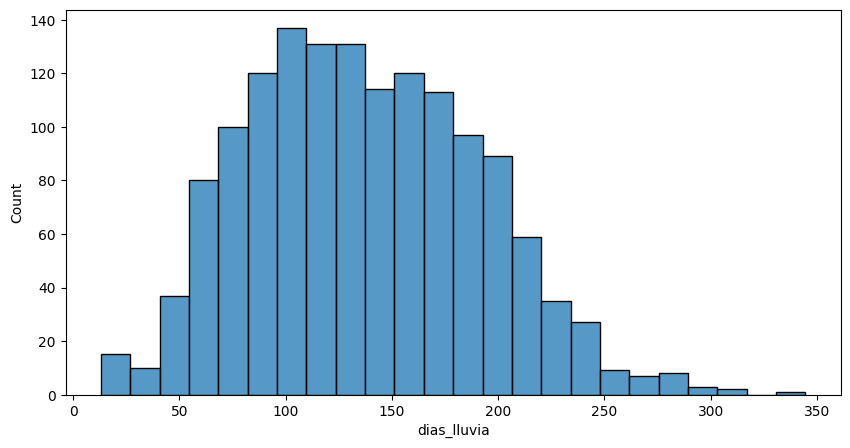

In [47]:
# Observasion visual para evaluar cual dato estadistico es el mejor para agrupar en funcion de municipio.
plt.figure(figsize=(10, 5))
sns.histplot(dato_lluvia['dias_lluvia'])
print('Media:',dato_lluvia['dias_lluvia'].mean())
print('Mediana:',dato_lluvia['dias_lluvia'].median())

In [48]:
# Por cada municipio √∫nico va a sacar la media de los datos correspondientes a este lugar
lluvia = dato_lluvia.groupby('municipio').agg({'dias_lluvia': 'mean'}).reset_index() #,'longitud': 'first', 'latitud': 'first'
lluvia

municipio  dias_lluvia
0        ABEJORRAL   177.800000
1         ABRIAQU√ç   200.600000
2          ACAC√çAS   195.700000
3           ACAND√ç   150.500000
4          ACEVEDO   157.650000
..             ...          ...
756  ZONA BANANERA    52.866667
757         √ÅBREGO   107.433333
758         √çQUIRA   166.500000
759         √öMBITA   170.200000
760          √öTICA    93.700000

[761 rows x 2 columns]

In [49]:
lluvia['municipio'].value_counts().sum() #evaluaci√≥n del m√©todo

np.int64(761)

Media: 139.6027481315589
Mediana: 138.05


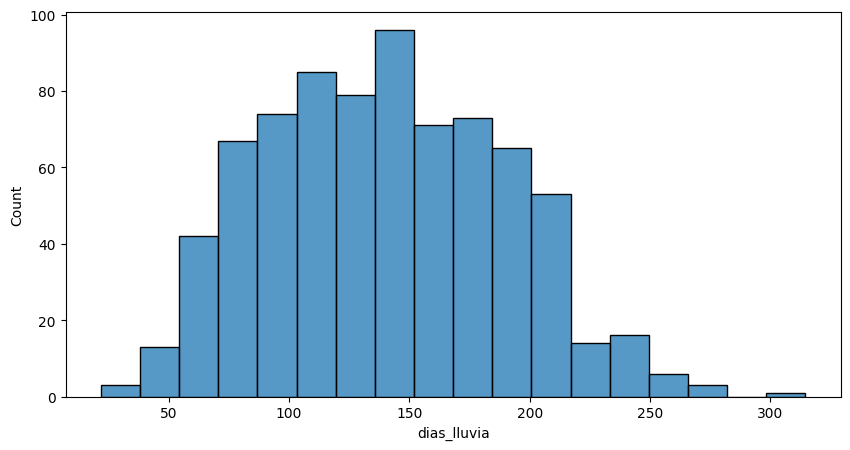

In [50]:
# Se observa nuevamente agrupacion similar
plt.figure(figsize=(10, 5))
sns.histplot(lluvia['dias_lluvia'])
print('Media:',lluvia['dias_lluvia'].mean())
print('Mediana:',lluvia['dias_lluvia'].median())

Notemos que de 1445 datos pasamos a tener 761 valores √∫nicos

**Unificaci√≥n de los datos**
---

Todos los datasets anteriormente tienen en com√∫n la columna de municipios por lo que esta va a ser la clave de unificaci√≥n. Este m√©todo crea una nueva tabla que de la misma manera que antes necesita un tratamiento de datos


**1. Unificaci√≥n y organizaci√≥n de datos de viento y lluvia**

In [51]:
# Se utiliza pd.merge left=viento right= lluvia para un dataframe en el cual
#municipio y velocidad_viento permaneceran con los mismos registros y se hara una comparasion con lluvia. Si los datos 'municipio' es un match en ambos datasets se ubica los datos que corresponda de 'dias_lluvia'. Si no se encuntran datos en 'dias_lluvia' se retorna un NaN. Si al hacer el match no habr√≠a datos en 'velocidad_viento' se descartar√≠a la fila completa 'municipio'	'dias_lluvia' de el dataframe lluvia.
df_clima = pd.merge(left= viento, right= lluvia, left_on='municipio', right_on= 'municipio', how='left')
df_clima

municipio  velocidad_viento  dias_lluvia
0             ACAND√ç          1.200000   150.500000
1            ACEVEDO          1.748343   157.650000
2          AGUACHICA          1.300000    91.533333
3    AGUST√çN CODAZZI          1.100000    79.600000
4            ALBANIA          4.350000          NaN
..               ...               ...          ...
295            YOPAL          0.600000   149.600000
296        ZETAQUIR√Å          0.550000   179.000000
297        ZIPAQUIR√Å          2.200000   147.350000
298    ZONA BANANERA          0.850000    52.866667
299           √ÅBREGO          1.900000   107.433333

[300 rows x 3 columns]

In [52]:
df_clima.info() #Evaluaci√≥n de las condiciones de los datos del dataframe cuantitatrivos o nominales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         300 non-null    object 
 1   velocidad_viento  300 non-null    float64
 2   dias_lluvia       222 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.2+ KB


**Tratamiento de datos**

In [53]:
df_clima.isnull().sum() #Conteo de valores nulos

municipio            0
velocidad_viento     0
dias_lluvia         78
dtype: int64

Media: 145.13079319829322
Mediana: 142.2


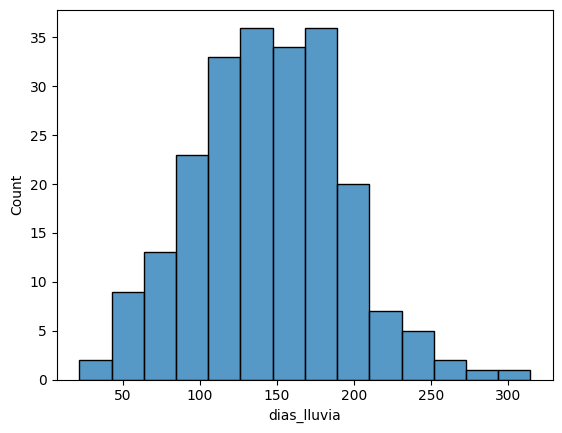

In [54]:
# Se observa una similitud numerica entre media y mediana
sns.histplot(df_clima['dias_lluvia'])
print('Media:',df_clima['dias_lluvia'].mean())
print('Mediana:', df_clima['dias_lluvia'].median())

N√≥temos que la distribuci√≥n de los datos es uniforme por lo que para el tratamiento de datos nulos se recomienda la **MEDIA**

Media: 1.6422269822898334
Mediana: 1.35


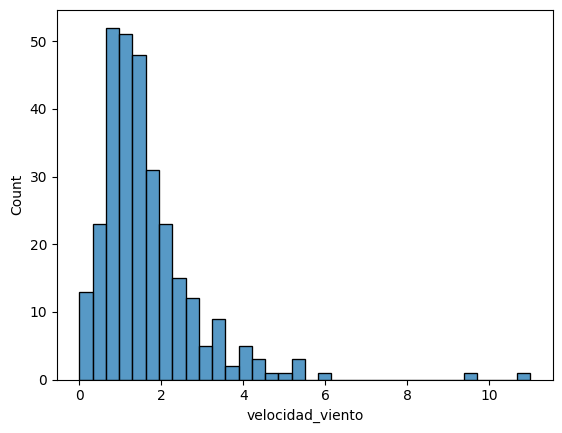

In [55]:
sns.histplot(df_clima['velocidad_viento'])
print('Media:',df_clima['velocidad_viento'].mean())
print('Mediana:', df_clima['velocidad_viento'].median())

N√≥temos que la distribuci√≥n de los datos est√° afectada por los datos at√≠picos  por lo que para el tratamiento de datos nulos se recomienda la **MEDIANA**

Manejo de datos faltantes

In [56]:
# Se rellenan los datos faltantes de los d√≠as de lluvia con el valor de la media
df_clima['dias_lluvia'] = df_clima['dias_lluvia'].fillna(df_clima['dias_lluvia'].mean())
df_clima

municipio  velocidad_viento  dias_lluvia
0             ACAND√ç          1.200000   150.500000
1            ACEVEDO          1.748343   157.650000
2          AGUACHICA          1.300000    91.533333
3    AGUST√çN CODAZZI          1.100000    79.600000
4            ALBANIA          4.350000   145.130793
..               ...               ...          ...
295            YOPAL          0.600000   149.600000
296        ZETAQUIR√Å          0.550000   179.000000
297        ZIPAQUIR√Å          2.200000   147.350000
298    ZONA BANANERA          0.850000    52.866667
299           √ÅBREGO          1.900000   107.433333

[300 rows x 3 columns]

In [57]:
df_clima.isnull().sum() #No se observan nulos

municipio           0
velocidad_viento    0
dias_lluvia         0
dtype: int64

In [58]:
df_clima['municipio'].value_counts().sum() #evaluaci√≥n del m√©todo

np.int64(300)

**Visualizaci√≥n de los datos**

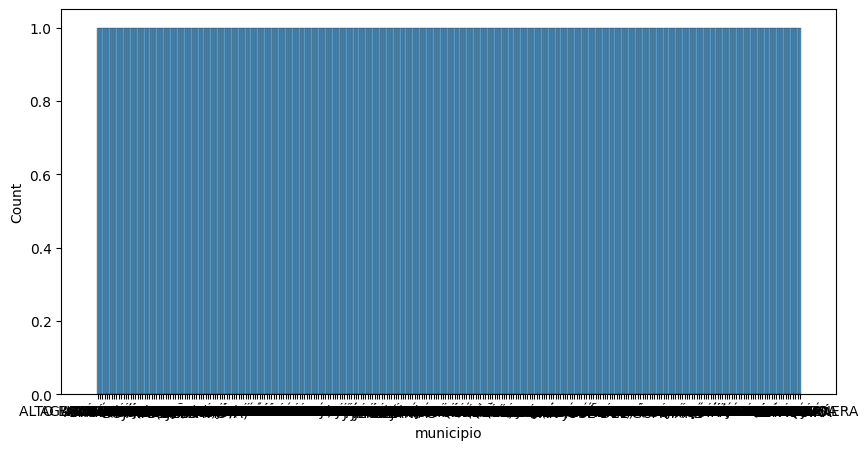

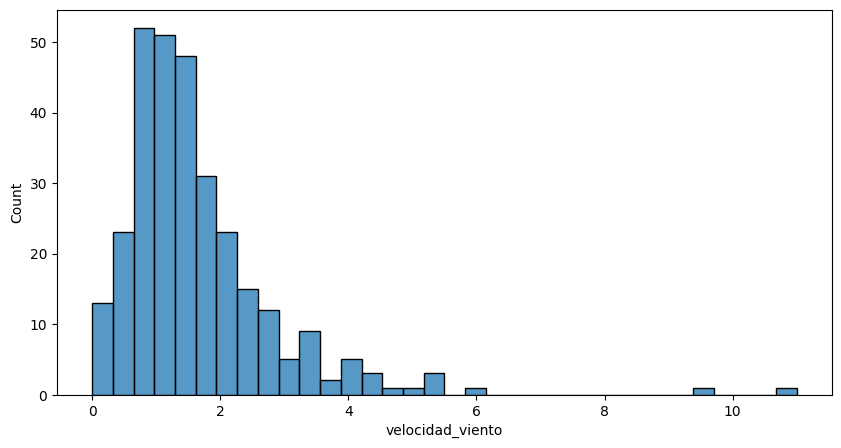

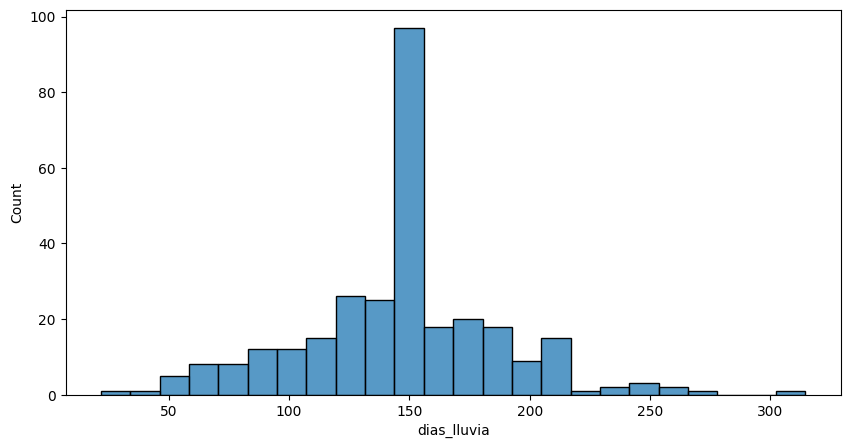

In [59]:
for col in df_clima.columns:
  plt.figure(figsize=(10, 5))
  sns.histplot(df_clima[col])


Not√©mos que debido al manejo que se les di√≥ a los datos, la distribuci√≥n de los d√≠as de lluvia cambi√≥

<Axes: >

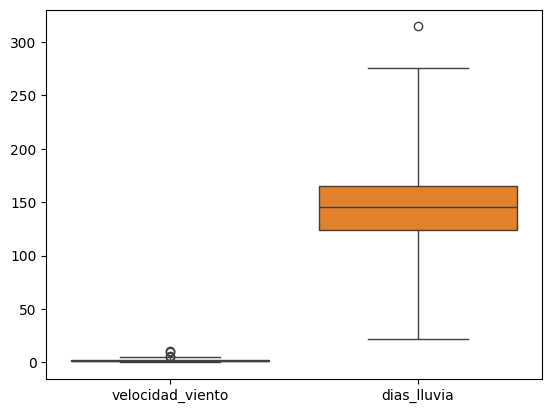

In [60]:
#Visualizaci√≥n de los datos para evaluar datos at√≠picos
climas = df_clima[['velocidad_viento', 'dias_lluvia']]
sns.boxplot(climas, whis=3)

Not√©mos que las escalas de los datos est√°n muy diferentes por lo que no se puede ver el comportamiento de la variable de la velocidad del viento

**2. Unificaci√≥n y organizaci√≥n de datos de energ√≠a y clima**

In [61]:
# Se utiliza pd.merge left=df_clima right= energy para un dataframe en el cual
#municipio velocidad_viento dias_lluvia permaneceran con los mismos registros y se hara una comparasion con energy. Si los datos 'municipio' es un match en ambos datasets se ubica los datos que corresponda en dichas filas. Si no se encuntran los datos de la izquierda retorna un NaN. Si al hacer el match no habr√≠a datos numericos en los datos de la derecha se descartar√≠a la fila completa de energy'.
df_unificado = pd.merge(left = df_clima, right = energy, left_on='municipio', right_on= 'municipio', how='left')
df_unificado

municipio  velocidad_viento  dias_lluvia  potencia_m  \
0             ACAND√ç          1.200000   150.500000      898.57   
1            ACEVEDO          1.748343   157.650000         NaN   
2          AGUACHICA          1.300000    91.533333         NaN   
3    AGUST√çN CODAZZI          1.100000    79.600000         NaN   
4            ALBANIA          4.350000   145.130793         NaN   
..               ...               ...          ...         ...   
295            YOPAL          0.600000   149.600000         NaN   
296        ZETAQUIR√Å          0.550000   179.000000         NaN   
297        ZIPAQUIR√Å          2.200000   147.350000         NaN   
298    ZONA BANANERA          0.850000    52.866667         NaN   
299           √ÅBREGO          1.900000   107.433333         NaN   

     energia_activa  energia_reactiva  
0          377087.5          135449.0  
1               NaN               NaN  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN  
..              ...               ...  
295             NaN               NaN  
296             NaN               NaN  
297             NaN               NaN  
298             NaN               NaN  
299             NaN               NaN  

[300 rows x 6 columns]

Not√©mos que de 291 datos del dataset final hay una cantidad de 268 nulos para el dataset de las energ√≠as. Este caso se da porque el dataset de base tiene m√°s datos que la tabla visitante, sin que coincidan los municipios, por lo tanto llena los espacios con nulos.

Dado este caso se propone el m√©todo de imputaci√≥n de valores el cual usa ######################

**Manejo de datos nulos: M√©todo de imputaci√≥n**

  1. Separaci√≥n de los datos nulos

In [62]:
# Primero se separan los datos faltantes en una tabla
nulos = pd.DataFrame(
    {'potencia_m': df_unificado['potencia_m'],
    'energia_activa': df_unificado['energia_activa'],
    'energia_reactiva': df_unificado['energia_reactiva']
}
)
nulos

potencia_m  energia_activa  energia_reactiva
0        898.57        377087.5          135449.0
1           NaN             NaN               NaN
2           NaN             NaN               NaN
3           NaN             NaN               NaN
4           NaN             NaN               NaN
..          ...             ...               ...
295         NaN             NaN               NaN
296         NaN             NaN               NaN
297         NaN             NaN               NaN
298         NaN             NaN               NaN
299         NaN             NaN               NaN

[300 rows x 3 columns]

In [63]:
nulos.info() #Evaluaci√≥n de las caracter√≠sticas de la tabla

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   potencia_m        24 non-null     float64
 1   energia_activa    24 non-null     float64
 2   energia_reactiva  24 non-null     float64
dtypes: float64(3)
memory usage: 7.2 KB


  2. Imputaci√≥n de valores

In [64]:
nulos['potencia_m'] = nulos['potencia_m'].fillna(nulos['potencia_m'].mean())


In [65]:
nulos['energia_activa'] = nulos['energia_activa'].fillna(nulos['energia_activa'].mean())


In [66]:
nulos['energia_reactiva'] = nulos['energia_reactiva'].fillna(nulos['energia_reactiva'].mean())
nulos

potencia_m  energia_activa  energia_reactiva
0        898.57   377087.500000     135449.000000
1       1773.74   991021.479167     279952.204167
2       1773.74   991021.479167     279952.204167
3       1773.74   991021.479167     279952.204167
4       1773.74   991021.479167     279952.204167
..          ...             ...               ...
295     1773.74   991021.479167     279952.204167
296     1773.74   991021.479167     279952.204167
297     1773.74   991021.479167     279952.204167
298     1773.74   991021.479167     279952.204167
299     1773.74   991021.479167     279952.204167

[300 rows x 3 columns]

Media: 1773.74
Mediana: 1773.74
Media: 991021.4791666669
Mediana: 991021.4791666666
Media: 279952.20416666666
Mediana: 279952.20416666666


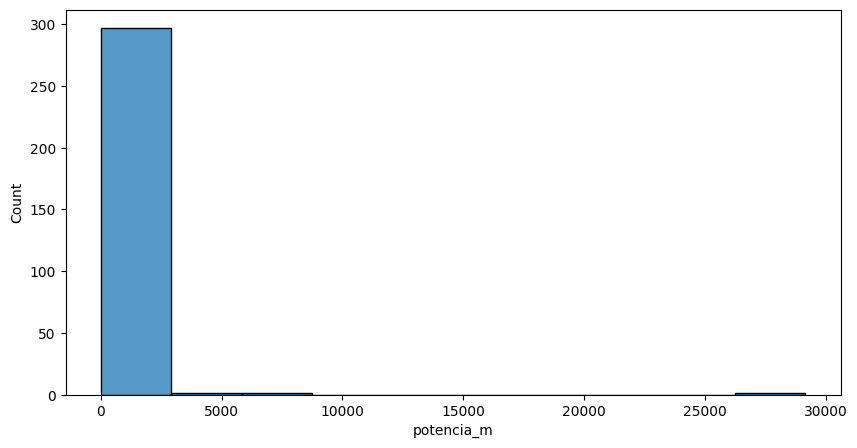

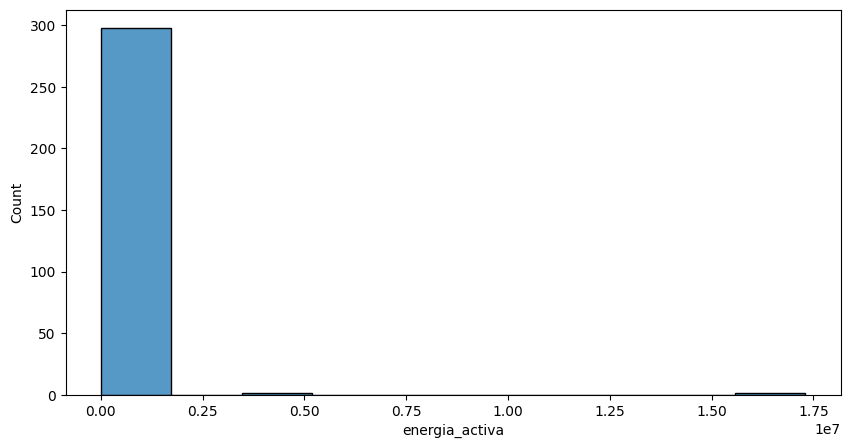

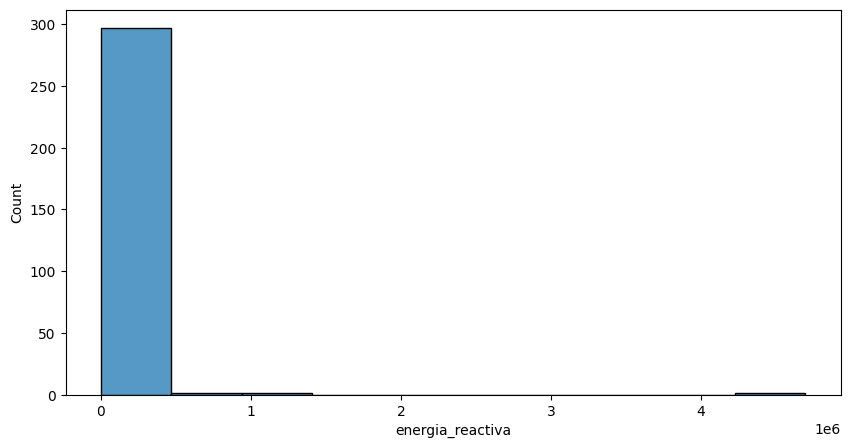

In [67]:
for col in nulos.columns:
  plt.figure(figsize=(10, 5))
  sns.histplot(nulos[col])
  print('Media:',nulos[col].mean())
  print('Mediana:', nulos[col].median())

  3. Uni√≥n de los datos imputados en el dataset final

In [68]:
# Uni√≥n de los datos de clima y las energ√≠as lado a lado sin cambios.
df_viabilidad = pd.concat([df_clima, nulos], axis=1)
df_viabilidad

municipio  velocidad_viento  dias_lluvia  potencia_m  \
0             ACAND√ç          1.200000   150.500000      898.57   
1            ACEVEDO          1.748343   157.650000     1773.74   
2          AGUACHICA          1.300000    91.533333     1773.74   
3    AGUST√çN CODAZZI          1.100000    79.600000     1773.74   
4            ALBANIA          4.350000   145.130793     1773.74   
..               ...               ...          ...         ...   
295            YOPAL          0.600000   149.600000     1773.74   
296        ZETAQUIR√Å          0.550000   179.000000     1773.74   
297        ZIPAQUIR√Å          2.200000   147.350000     1773.74   
298    ZONA BANANERA          0.850000    52.866667     1773.74   
299           √ÅBREGO          1.900000   107.433333     1773.74   

     energia_activa  energia_reactiva  
0     377087.500000     135449.000000  
1     991021.479167     279952.204167  
2     991021.479167     279952.204167  
3     991021.479167     279952.204167  
4     991021.479167     279952.204167  
..              ...               ...  
295   991021.479167     279952.204167  
296   991021.479167     279952.204167  
297   991021.479167     279952.204167  
298   991021.479167     279952.204167  
299   991021.479167     279952.204167  

[300 rows x 6 columns]

In [69]:
df_viabilidad.isnull().sum() #Conteo de los datos

municipio           0
velocidad_viento    0
dias_lluvia         0
potencia_m          0
energia_activa      0
energia_reactiva    0
dtype: int64

Los proyectos de energ√≠a renovable, tipo e√≥lico o solar, est√°n fuertemente relacionados por el clima por lo que es posible determinar, prontamente si un municipio cumple con las especificaciones clim√°ticas.

Por un lado, un proyecto de energ√≠a e√≥lica requiere que haya una velocidad del viento de  m√≠nimo 3,5 m/s. Por el otro lado, un proyecto de energ√≠a solar es viable en lugares donde llueva menos de 90 d√≠as al a√±o. El tipo solar requiere de muchos m√°s factores que solo los d√≠as despejados para determinar su viabilidad, sin embargo, la posici√≥n geogr√°fica del pa√≠s brinda una radiaci√≥n solar suficiente para que un proyecto de esta clase se d√© de manera exitosa con menos de 150 d√≠as de lluvia anual.

In [70]:
#Creaci√≥n de la variable viabilidad a trav√©s del an√°lisis clim√°tico de los municipios
  #La columna viabilidad responde a 1 si el municipio cumple con las condiciones del clima y 0 si no es as√≠
df_viabilidad.loc[:, 'viabilidad'] = ((df_viabilidad['dias_lluvia'] < 150) | (df_viabilidad['velocidad_viento'] > 3.5)).astype(int)
df_viabilidad

municipio  velocidad_viento  dias_lluvia  potencia_m  \
0             ACAND√ç          1.200000   150.500000      898.57   
1            ACEVEDO          1.748343   157.650000     1773.74   
2          AGUACHICA          1.300000    91.533333     1773.74   
3    AGUST√çN CODAZZI          1.100000    79.600000     1773.74   
4            ALBANIA          4.350000   145.130793     1773.74   
..               ...               ...          ...         ...   
295            YOPAL          0.600000   149.600000     1773.74   
296        ZETAQUIR√Å          0.550000   179.000000     1773.74   
297        ZIPAQUIR√Å          2.200000   147.350000     1773.74   
298    ZONA BANANERA          0.850000    52.866667     1773.74   
299           √ÅBREGO          1.900000   107.433333     1773.74   

     energia_activa  energia_reactiva  viabilidad  
0     377087.500000     135449.000000           0  
1     991021.479167     279952.204167           0  
2     991021.479167     279952.204167           1  
3     991021.479167     279952.204167           1  
4     991021.479167     279952.204167           1  
..              ...               ...         ...  
295   991021.479167     279952.204167           1  
296   991021.479167     279952.204167           0  
297   991021.479167     279952.204167           1  
298   991021.479167     279952.204167           1  
299   991021.479167     279952.204167           1  

[300 rows x 7 columns]

In [71]:
df_viabilidad['viabilidad'].value_counts() #Conteo de los datos de viabilidad

viabilidad
1    210
0     90
Name: count, dtype: int64

# **3. Preprocesamiento de los datos**

Previamente se hizo un scouting de la condicione de los datos, pero ahora se entra m√°s en detalle

**Visualizaci√≥n de las variables**

<Axes: >

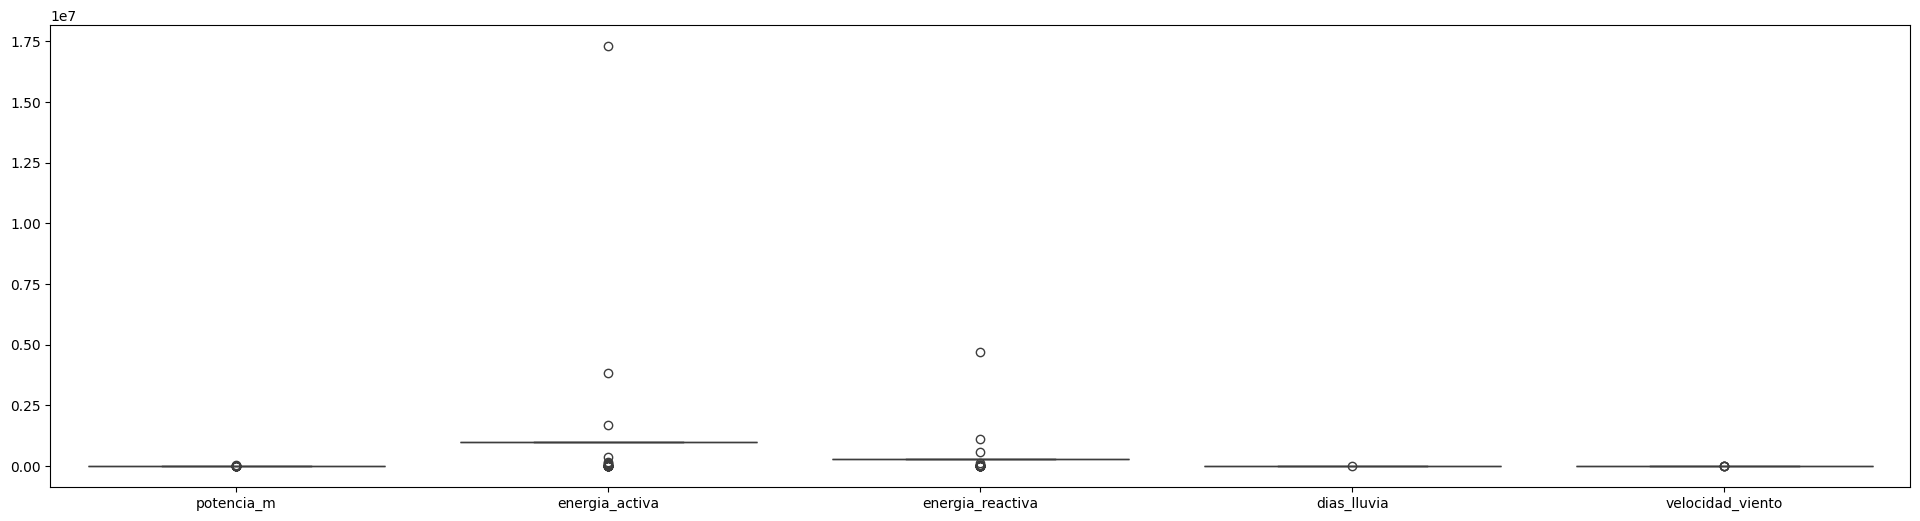

In [72]:
# Visualizaci√≥n del comportamiento de cada variable
plt.figure(figsize=(24, 6))
variables = df_viabilidad[['potencia_m', 'energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]
sns.boxplot(variables, whis=3)

Not√©mos que los datos presentan comportamientos at√≠picos que afectar√°n al modelo por lo que se recomienda hacer un tratamiento y una escalaci√≥n de los mismos.

<Axes: >

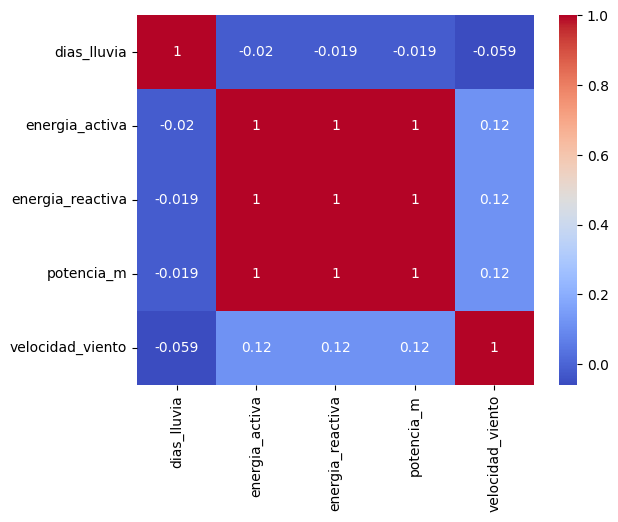

In [73]:
#Evaluaci√≥n de correlaci√≥n en el dataset final
correlacion = df_viabilidad[['dias_lluvia', 'energia_activa', 'energia_reactiva', 'potencia_m', 'velocidad_viento']].corr()

sns.heatmap(correlacion, annot=True, cmap='coolwarm')

La correlaci√≥n aqu√≠ observada se debe, principalmente al comportamiento de los datos originales. Por otro lado, el tratamiento de imputaci√≥n hace que sea m√°s homog√©neo este comportamiento.

# **4. Entrenamiento del Modelo**

Para el caso de estos datos se determin√≥ que la naturaleza del modelo deber√≠a ser de clasificaci√≥n. Este va a evaluar las variables energ√©ticas y clim√°ticas para predecir si un municipio es viable o no para un proyecto de energ√≠a renobale

## Modelo de clasificaci√≥n NAIVE BAYES
---

A la par que se crea el modelo tambi√©n se escalan los datos por medio del RobustScaler(), que nos brinda la facilidad de escalar y tratar los datos at√≠picos.

In [74]:
# se separan x de entradas y salida
x = df_viabilidad[[ 'energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]
y = df_viabilidad['viabilidad']
# Se divide set de entranmiento y prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(x, y, test_size=0.2, random_state=42)
# Se utiliza escalador para las x, contiene outliers, no para y por que es 1 y 0
escalador = RobustScaler()
x_entrenamientox = escalador.fit_transform(x_entrenamiento)
x_pruebax = escalador.transform(x_prueba)
# Modelo de clasificasio que mejor se ajusto
naive_model = MultinomialNB()
naive_model.fit(x_entrenamiento, y_entrenamiento)
predicciones = naive_model.predict(x_prueba)

# **5. Evaluaci√≥n del Modelo**

La evaluaci√≥n del modelo se hizo a trav√©s de diferentes m√©tricas y herramientas para segurar el correcto funcionamiento del mismo

**Cross Validation:** #########################

In [75]:
#Estas metricas evaluann el modelo y 'x' y 'y' seleccionadas en 3 particiones y dan un puntaje alto.
kfold1 = KFold(n_splits=3, shuffle=True, random_state=42)
cv_score1 = cross_val_score(naive_model, x, y, cv=kfold1)
print(cv_score1)
print(cv_score1.mean())

[0.86 0.92 0.87]
0.8833333333333333


**Accuracy y Classification report:** ###############################

In [76]:
print(classification_report(y_prueba, predicciones))
print('Accuracy:', accuracy_score(y_prueba, predicciones))


              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.81      0.90      0.85        39

    accuracy                           0.80        60
   macro avg       0.79      0.76      0.77        60
weighted avg       0.80      0.80      0.79        60

Accuracy: 0.8


**Matriz de confusi√≥n : ################################

In [77]:
matriz1 = confusion_matrix(y_prueba, predicciones)
print(matriz1)

[[13  8]
 [ 4 35]]


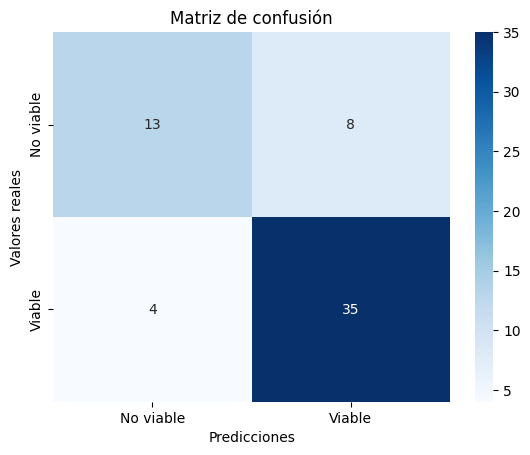

In [78]:
# Visualizaci√≥n de la matris de confusi√≥n
labels = ['No viable', 'Viable']

sns.heatmap(matriz1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusi√≥n')
plt.show()

**AUC y Curva ROC:**

In [79]:
predicciones = naive_model.predict_proba(x_prueba)[:, 1]

In [80]:
fpr, tpr, thresholds = roc_curve(y_prueba, predicciones)
auc = roc_auc_score(y_prueba, predicciones)
print(f"AUC: {auc}")

AUC: 0.9084249084249084


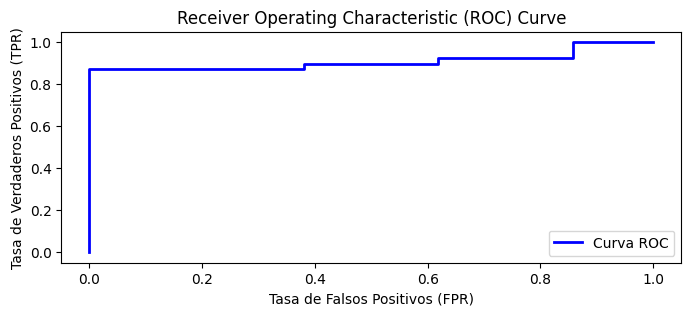

In [81]:
plt.figure(figsize=(8, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC' % auc)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Comportamiento de Residuos:**

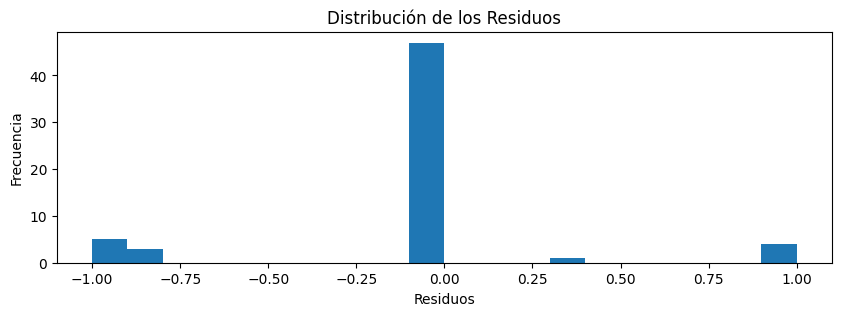

In [82]:
plt.figure(figsize=(10, 3))
residuos = y_prueba - predicciones
plt.hist(residuos, bins=20)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribuci√≥n de los Residuos")
plt.show()

# **6. Implementaci√≥n**

Se tranforma el modelo en una aplicaci√≥n amigable para el usuario, con la que este puede obtener informaci√≥n adicional acerca del contexto de la predicci√≥n.

##**Creaci√≥n de una funci√≥n de evaluaci√≥n de viabilidad:**
Con esta el usuario puede ingresar un municipio de colombia y este va a arrojaruna predicci√≥n basada en la informaci√≥n recopilada

In [83]:
def predecir_viabilidad_municipio(municipio, modelo, df_viabilidad):

  municipio = municipio.upper()  # Convertir el nombre del municipio a may√∫sculas

  # Buscar el municipio en el DataFrame
  datos_municipio = df_viabilidad[df_viabilidad['municipio'] == municipio]

  if datos_municipio.empty:
    return f"No se encuentran datos suficientes para {municipio}"

  # Obtener las caracter√≠sticas del municipio
  caracteristicas = datos_municipio[['energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]

  # Realizar la predicci√≥n
  prediccion = modelo.predict(caracteristicas)[0]

  # Justificaci√≥n de la predicci√≥n
  justificacion = ""
  if prediccion == 1:
    justificacion = f"El municipio {municipio} es viable para proyectos de energ√≠a renovable. "
    if datos_municipio['dias_lluvia'].values[0] < 150:
      justificacion += "Se recomienda un proyecto de energ√≠a Solar debido a que llueve menos de 150 al a√±o. "
    elif datos_municipio['velocidad_viento'].values[0] > 3.5:
      justificacion += "Se recomienda un proyecto de energ√≠a E√≥lica debido a que la velocidad promedio del viento es superior al 3.5 m/s."
    elif datos_municipio['velocidad_viento'].values[0] > 3.5 and datos_municipio['dias_lluvia'].values[0] < 150:
      justificacion += "Los proyectos de energ√≠a Solar y E√≥lico son ideales por condiciones clim√°ticas ideales."
  else:
    justificacion = f"El municipio {municipio} NO es viable para proyectos de energ√≠a renovable. "
    if datos_municipio['dias_lluvia'].values[0] > 150 or datos_municipio['velocidad_viento'].values[0] < 3.5:
      justificacion += "No se recomienda un proyecto de energ√≠a E√≥lica debido a que no existen buenas condiciones clim√°ticas. "

  return justificacion

##**Despliegue del modelo:**
A trav√©s del archivo binarizado es posible crear un aplicativo remoto disponible para los usuarios

In [84]:
import pickle
with open('modelo.pkl', 'wb') as f:
    pickle.dump(naive_model, f)